# Segmenting restaurant delivery customers using RFM

### C, a company created more than two decades ago, owns several restaurants in Cyprus. These restaurants are grouped into different brands, according to the restaurants concept, location, and type of cuisine.
### One of the first brands created by C, specialized in Asian food, mainly in Chinese food, is struggling to maintain their profit margin and continuous growth due to increasing competition and customers’ changes of habits. To try to revert this process, C wants to take advantage of their sales data to understand customers’ patterns of consumption and preferences. 

This is a simple example. Not all CRISP-DM phases are seen in high detail.

Nuno António - Rev. 1.00 - October, 2020

### Dataset description

#### This is real data. Some quality issues may arise. Please, do not share the data outside this course.

Each row in the dataset represents a document line (invoice line). The dataset is composed of the following columns:
- **DocNumber**: number of the document. The document number repeats in as many rows as the rows in the original document (invoice)
- **ProductDesignation**: product designation
- **ProductFamily**: name of the family of the product. A product can only be member of one only family
- **Qty**: quantity
- **TotalAmount**: sale price of the total quantity
- **InvoiceDateHour**: date and hour when the document was issued
- **EmployeeID**: ID of the employee who issued the document
- **IsDelivery**: indication if sale was a delivery or a dine-inn (1: delivery, 0: dine-inn)
- **Pax**: number of persons at the table
- **CustomerID**: ID of the customer (if a customer record was assigned to the sale)
- **CustomerCity**: city of the customer (usually only employed in delivery)
- **CustomerSince**: date of creation of the customer

### Initial setup and modules/packages loading

In [2]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data understanding

In [3]:
# Load data 
ds = pd.read_csv('AsianRestaurantChain_Cyprus_2018.csv', sep=";")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84109 entries, 0 to 84108
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DocNumber           84109 non-null  object 
 1   ProductDesignation  84109 non-null  object 
 2   ProductFamily       84109 non-null  object 
 3   Qty                 84109 non-null  float64
 4   TotalAmount         84109 non-null  float64
 5   InvoiceDateHour     84109 non-null  object 
 6   EmployeeID          84109 non-null  int64  
 7   IsDelivery          84109 non-null  int64  
 8   Pax                 84109 non-null  int64  
 9   CustomerID          84109 non-null  int64  
 10  CustomerCity        31248 non-null  object 
 11  CustomerSince       29142 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 7.7+ MB


In [4]:
# Display top 10 rows
ds.head(10)

,DocNumber,ProductDesignation,ProductFamily,Qty,TotalAmount,InvoiceDateHour,EmployeeID,IsDelivery,Pax,CustomerID,CustomerCity,CustomerSince
0,TKD0320000012018,1/2 DUCK,STARTERS,1.0,27.1,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
1,TKD0320000012018,SPRING ROLL,STARTERS,8.0,17.6,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
2,TKD0320000012018,SWEET SOUR CHICKEN,MEAT,2.0,20.2,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
3,TKD0320000012018,LEMON CHICKEN,MEAT,1.0,10.1,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
4,TKD0320000012018,BEEF BBS,SIZZLING,1.0,12.6,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
5,TKD0320000012018,BEEF BBS,SIZZLING,1.0,12.6,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
6,TKD0320000012018,STEAMED RICE,RICE,2.0,8.8,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
7,TKD0320000012018,SPECIAL MONTPARNASSE RICE,RICE,1.0,6.3,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
8,TKD0320000012018,NOODLES WITH MEAT,RICE,2.0,15.8,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN
9,TKD0320000012018,NO MEAT,HOLDS,2.0,0.0,2018-01-01 19:12:12.000,2,1,1,53908,LEYKOSIA,NaN


In [5]:
# Summary statistics for all variables
summary=ds.describe(include='all')
summary=summary.transpose()
summary.head(len(summary))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DocNumber,84109,11147,TK0110053522018,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductDesignation,84109,255,MINERAL WATER 1.5LT,7061,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductFamily,84109,27,STARTERS,14148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Qty,84109,NaN,NaN,NaN,1.26126,0.92378,1,1,1,1,53
TotalAmount,84109,NaN,NaN,NaN,9.83142,20.6568,0,3,6.9,12.6,3000
InvoiceDateHour,84109,11146,2018-12-24 22:59:54.000,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeID,84109,NaN,NaN,NaN,3.59122,3.68202,2,2,2,5,27
IsDelivery,84109,NaN,NaN,NaN,0.371518,0.483213,0,0,0,1,1
Pax,84109,NaN,NaN,NaN,3.3008,3.69379,0,1,2,4,200
CustomerID,84109,NaN,NaN,NaN,12633.1,21952.1,0,0,0,16429,69101


In [6]:
# Check missing values
print(ds.isnull().sum())

DocNumber                 0
ProductDesignation        0
ProductFamily             0
Qty                       0
TotalAmount               0
InvoiceDateHour           0
EmployeeID                0
IsDelivery                0
Pax                       0
CustomerID                0
CustomerCity          52861
CustomerSince         54967
dtype: int64


In [7]:
# Exploration of categorical variables: cross table of job and education
table1 = pd.crosstab(index=np.where(ds['CustomerID']>0,1,0), columns=ds['IsDelivery'])
table1.index=['Without customer ID','With customer ID']
table1

IsDelivery,0,1
Without customer ID,52861,0
With customer ID,0,31248


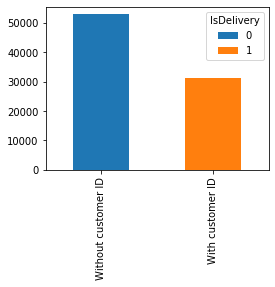

In [8]:
# Visual exploration of the cross table
table1.plot(kind="bar", 
                 figsize=(4,3),
                 stacked=True)

### Data preparation

In [9]:
# Drop-non delivery customers
ds = ds[ds['IsDelivery'] == 1]

In [10]:
# Format data types

cols = ['InvoiceDateHour']
ds[cols] = ds[cols].apply(pd.to_datetime)

cols = ['DocNumber','ProductDesignation']
ds[cols] = ds[cols].astype(str)

In [11]:
# Compute totals per customer
dateMax = ds.InvoiceDateHour.max()
X = ds.groupby(['CustomerID']).agg({'InvoiceDateHour': lambda date: (dateMax - date.max()).days,
                                    'DocNumber': lambda i: len(i.unique()),
                                    'TotalAmount': [sum]}).fillna(0)
X.columns = ['Recency', 'Frequency', 'Monetary']

In [12]:
# Show first 5 customers
X.head(5)

,Recency,Frequency,Monetary
CustomerID,,,
6,98,1,118.12
24,104,1,39.56
25,1,2,96.02
31,9,2,176.26
34,204,1,61.50


### Modeling

In [13]:
# Determinining RFM cutting points based on the quartiles (default for pandas "describe")
cols = ['Recency','Frequency','Monetary']
table = X[cols].describe()
table

,Recency,Frequency,Monetary
count,2315.000000,2315.000000,2315.000000
mean,152.409935,2.101944,94.695840
std,115.230804,2.707104,119.852621
min,0.000000,1.000000,0.000000
25%,44.000000,1.000000,37.000000
50%,134.000000,1.000000,56.000000
75%,256.000000,2.000000,102.830000
max,364.000000,42.000000,1725.880000


In [14]:
# Calculate RMF scores

# Function
def RFMScore(x, col):
    if x <= X.quantile(0.25)[col]:
        return '1'
    elif x <= X.quantile(0.5)[col]:
        return '2'
    elif x <= X.quantile(0.75)[col]:
        return '3'
    else:
        return '4'

# Process
X['RScore'] = X['Recency'].apply(RFMScore, col='Recency')
X['FScore'] = X['Frequency'].apply(RFMScore, col='Frequency')
X['MScore'] = X['Monetary'].apply(RFMScore, col='Monetary')

In [15]:
# Show first 5
X.head(5)

,Recency,Frequency,Monetary,RScore,FScore,MScore
CustomerID,,,,,,
6,98,1,118.12,2,1,4
24,104,1,39.56,2,1,2
25,1,2,96.02,1,3,3
31,9,2,176.26,1,3,4
34,204,1,61.50,3,1,3


In [16]:
# Create a column with full RMF score and sort the results

# Transform to string
cols = ['RScore','FScore','MScore']
X[cols] = X[cols].astype(str)

# Concatenate
X['RFMScore'] = X['RScore'] + X['FScore'] + X['MScore']

# Sort
X = X.sort_values(by=['RFMScore'])

In [17]:
# Show first 5
X.head(5)

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore
CustomerID,,,,,,,
31706,37,1,22.06,1,1,1,111
8066,23,1,25.56,1,1,1,111
40739,37,1,22.90,1,1,1,111
7998,12,1,32.80,1,1,1,111
28383,20,1,36.76,1,1,1,111


### Evaluation

In [18]:
# Calculate statistics per RFM segment
RFMStats = X.reset_index().groupby(['RFMScore']).agg({'CustomerID': lambda i: len(i.unique()),
                                                      'Recency': 'mean',
                                                      'Frequency': 'mean',
                                                      'Monetary': 'mean'}).fillna(0)
RFMStats.columns = ['NrCustomers','avgRecency', 'avgFrequency', 'avgMonetary']

In [19]:
# Show statistics
RFMStats

,NrCustomers,avgRecency,avgFrequency,avgMonetary
RFMScore,,,,
111,74,19.635135,1.000000,28.571892
112,96,19.322917,1.000000,44.876458
113,68,17.250000,1.000000,69.447353
114,17,13.058824,1.000000,135.654118
131,2,20.000000,2.000000,31.830000
132,15,21.733333,2.000000,51.249333
133,48,17.270833,2.000000,80.207917
134,42,15.904762,2.000000,154.142857
141,1,17.000000,4.000000,8.600000


In [20]:
# Check who are customers from segment "144"
X[X['RFMScore']=='144']

,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMScore
CustomerID,,,,,,,
44949,37,6,328.68,1,4,4,144
44944,4,10,399.32,1,4,4,144
44841,41,14,759.64,1,4,4,144
44827,39,6,247.72,1,4,4,144
34255,15,3,129.68,1,4,4,144
...,...,...,...,...,...,...,...
61226,2,9,613.70,1,4,4,144
58942,12,7,342.94,1,4,4,144
64990,3,4,104.28,1,4,4,144
